# AI Inference Energy Consumption Prediction Pipeline

This notebook covers the end-to-end pipeline for Challenge 1: predicting inference energy consumption of LLMs using real measurements.

- target GPU: NVIDIEA GPU
- target AI model: LLM model

## 1. Environment Setup & Library Installation

Before running this notebook, install the required libraries and Set up Git LFS in a terminal:

In [6]:
!pip install git-lfs datasets joblib xgboost scikit-learn matplotlib pandas numpy seaborn
!pip install lightgbm optuna --quiet


[notice] A new release of pip is available: 23.3.1 -> 25.1.1
[notice] To update, run: python -m pip install --upgrade pip

[notice] A new release of pip is available: 23.3.1 -> 25.1.1
[notice] To update, run: python -m pip install --upgrade pip


### Import necessary libraries

In [7]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.multioutput import MultiOutputRegressor
import lightgbm as lgb
import matplotlib.pyplot as plt
import joblib
import optuna
import glob
import xgboost as xgb
import seaborn as sns


## 2. Download the Dataset

Clone the full LLM Inference Energy Consumption dataset from Hugging Face if not already present.

In [8]:
import os
import subprocess
import shutil # For removing directories

# Define the repository URL and local directory name
repo_url = "https://huggingface.co/datasets/ohdoking/energy_consumption_by_model_and_gpu"
local_dir = "energy_consumption_by_model_and_gpu"

print(f"Checking for existing directory: {local_dir}")

# --- Step 1: Remove existing directory if it exists ---
if os.path.isdir(local_dir):
    print(f"Directory '{local_dir}' found. Removing it to get the latest version...")
    try:
        shutil.rmtree(local_dir)
        print(f"Successfully removed '{local_dir}'.")
    except OSError as e:
        print(f"Error removing directory '{local_dir}': {e}")
        print("Please ensure you have permissions to delete this directory or it's not in use.")
        exit(1) # Exit if removal fails as we can't proceed with a clean clone
else:
    print(f"Directory '{local_dir}' not found. Proceeding to clone.")

# --- Step 2: Ensure Git LFS is installed and clone the repository ---
print("Running git lfs install...")
try:
    # This command can be run safely multiple times; it just initializes LFS.
    subprocess.run(["git", "lfs", "install"], check=True)
    print("Git LFS installed/initialized.")
except subprocess.CalledProcessError as e:
    print(f"Error installing Git LFS: {e}")
    print("Please ensure Git LFS is installed on your system (e.g., `sudo apt-get install git-lfs` or `brew install git-lfs`).")
    exit(1) # Exit if LFS install fails

print(f"Cloning {repo_url} into {local_dir}...")
try:
    subprocess.run(["git", "clone", repo_url], check=True)
    print("Repository cloned successfully.")
except subprocess.CalledProcessError as e:
    print(f"Error cloning repository: {e}")
    exit(1) # Exit if cloning fails

print("Dataset retrieval complete.")

if not os.path.isdir("gpu_spec"):
    !git lfs install
    !git clone https://huggingface.co/datasets/ohdoking/gpu_spec

if not os.path.isdir("llm_model_specs"):
    !git lfs install
    !git clone https://huggingface.co/datasets/ohdoking/llm_model_specs


Checking for existing directory: energy_consumption_by_model_and_gpu
Directory 'energy_consumption_by_model_and_gpu' found. Removing it to get the latest version...
Successfully removed 'energy_consumption_by_model_and_gpu'.
Running git lfs install...
Error installing Git LFS: Command '['git', 'lfs', 'install']' returned non-zero exit status 1.
Please ensure Git LFS is installed on your system (e.g., `sudo apt-get install git-lfs` or `brew install git-lfs`).
Cloning https://huggingface.co/datasets/ohdoking/energy_consumption_by_model_and_gpu into energy_consumption_by_model_and_gpu...


git: 'lfs' is not a git command. See 'git --help'.

The most similar command is
	log
Cloning into 'energy_consumption_by_model_and_gpu'...


Repository cloned successfully.
Dataset retrieval complete.


## 3. Merge All CSV Files

After cloning places the repository in `llm-inference-energy-consumption/data`. We’ll explicitly set the path accordingly.

In [9]:
# Define the dataset directory (absolute path)
data_dir = "energy_consumption_by_model_and_gpu/data"

# Verify directory exists
if not os.path.isdir(data_dir):
    raise FileNotFoundError(f"Directory {data_dir} not found. Check if clone succeeded.")

# Gather all CSV file paths
csv_paths = glob.glob(os.path.join(data_dir, "*.csv"))
if len(csv_paths) == 0:
    raise ValueError(f"No CSV files found in {data_dir}. CSV paths: {csv_paths}")

# Read and concatenate CSVs
all_df = pd.concat([pd.read_csv(path) for path in csv_paths], ignore_index=True)

# Display dataset overview
print(f"Total samples: {len(all_df)}")
print("Columns:", all_df.columns.tolist())

# Save merged CSV to input/llm-inference-energy-consumption_data.csv
os.makedirs("input", exist_ok=True)
output_path = os.path.join("input", "llm-inference-energy-consumption_data.csv")
all_df.to_csv(output_path, index=False)
print(f"Merged CSV saved to {output_path}")

Total samples: 19119
Columns: ['model_name', 'huggingface_model', 'num_params', 'hidden_size', 'num_layers', 'vocab_size', 'seq_length', 'model_type', 'timestamp', 'hardware_cpu', 'hardware_gpu', 'hardware_ram', 'total_prompts', 'average_runtime', 'average_energy', 'average_co2', 'benchmark_timestamp', 'prompt_index', 'prompt_text', 'prompt_runtime', 'prompt_energy', 'prompt_co2', 'prompt_response']
Merged CSV saved to input/llm-inference-energy-consumption_data.csv


### Merge 2 csv files

In [10]:
# Load GPU spec data
gpu_spec_df = pd.read_csv("gpu_spec/data/nvidia_gpu.csv")
llm_spec_df = pd.read_csv("llm_model_specs/data/llm_models.csv")

# Load benchmark data
benchmark_df = pd.read_csv("input/llm-inference-energy-consumption_data.csv")

# Perform the merge
# We want to add GPU specs to the benchmark data, so we use a left merge on benchmark_df
merged_df = pd.merge(
    benchmark_df,
    gpu_spec_df,
    left_on='hardware_gpu',
    right_on='Model',
    how='left'
)

# Optional: Drop the redundant 'Model' column from gpu_spec_df after merge
# (It's often good practice if the merge key is already present in the left dataframe)
merged_df = merged_df.drop(columns=['Model'])

# Display the first few rows of the merged DataFrame to verify
print("Merged DataFrame Head:")
print(merged_df.head())

# To see all columns, you might need to adjust pandas display options
# pd.set_option('display.max_columns', None)
# print(merged_df.head())

os.makedirs("input", exist_ok=True)
output_with_gpu_path = os.path.join("input", "llm-inference-energy-consumption_data_with_gpu_info.csv")
merged_df.to_csv(output_with_gpu_path, index=False)
print(f"Merged CSV saved to {output_with_gpu_path}")

# You can save the result to a new CSV file if needed:
# merged_df.to_csv("benchmark_with_gpu_specs.csv", index=False)
# print("\nMerged data saved to 'benchmark_with_gpu_specs.csv'")

Merged DataFrame Head:
         model_name         huggingface_model num_params  hidden_size  \
0  GPT-2 (XL, 1.5B)  openai-community/gpt2-xl     1.558B         1600   
1  GPT-2 (XL, 1.5B)  openai-community/gpt2-xl     1.558B         1600   
2  GPT-2 (XL, 1.5B)  openai-community/gpt2-xl     1.558B         1600   
3  GPT-2 (XL, 1.5B)  openai-community/gpt2-xl     1.558B         1600   
4  GPT-2 (XL, 1.5B)  openai-community/gpt2-xl     1.558B         1600   

   num_layers  vocab_size  seq_length            model_type  timestamp  \
0          48       50257        1024  Transformer (causal)     181111   
1          48       50257        1024  Transformer (causal)     181111   
2          48       50257        1024  Transformer (causal)     181111   
3          48       50257        1024  Transformer (causal)     181111   
4          48       50257        1024  Transformer (causal)     181111   

       hardware_cpu  ... prompt_runtime prompt_energy    prompt_co2  \
0  NVIDIA_RTX_A4000  .

## 3. Data preprocessing

In [12]:
# --- Configuration ---
DATA_PATH = "input/llm-inference-energy-consumption_data_with_gpu_info.csv"
MODEL_DIR = "models"
TEST_SIZE = 0.2
RANDOM_STATE = 42
OPTUNA_TRIALS = 50  # Number of Optuna trials for hyperparameter tuning
# --- Utility Functions ---
def parse_num_params(s):
    """Parses model parameters string (e.g., "7B", "1.1M") into a float in Billions."""
    if pd.isna(s):
        return np.nan
    s = str(s).strip().upper()
    if 'B' in s:
        return float(s.replace('B', ''))
    elif 'M' in s:
        return float(s.replace('M', '')) / 1000
    elif 'K' in s:
        return float(s.replace('K', '')) / 1000000
    try:
        return float(s)
    except ValueError:
        return np.nan


def parse_ram(s):
    """Parses RAM string (e.g., "16GB", "8MB") into a float in GB."""
    if pd.isna(s):
        return np.nan
    s = str(s).strip().upper()
    if 'GB' in s:
        return float(s.replace('GB', ''))
    elif 'MB' in s:
        return float(s.replace('MB', '')) / 1024
    try:
        return float(s)
    except ValueError:
        return np.nan


# --- Data Loading and Preprocessing ---
print("--- Loading Data ---")
df = pd.read_csv(DATA_PATH)

# Apply parsing functions for engineered features
df['num_params_B'] = df['num_params'].apply(parse_num_params)
df['hardware_ram_GB'] = df['hardware_ram'].apply(parse_ram)

# Define ALL target variables for multi-output regression
TARGET_COLS = ['average_runtime', 'average_energy', 'average_co2']

# Define columns to drop from the original DataFrame before defining X.
columns_to_drop_from_df = TARGET_COLS + [
    'timestamp',
    'benchmark_timestamp',
    'prompt_index',
    'prompt_text',
    'prompt_response',
    'num_params',
    'hardware_ram',
    'prompt_runtime',
    'prompt_energy',
    'prompt_co2',
    'hardware_cpu',
]

# Filter to only existing columns before dropping
columns_to_drop_existing = [
    col for col in columns_to_drop_from_df if col in df.columns
]
X = df.drop(columns=columns_to_drop_existing)
y = df[TARGET_COLS]

print(f"Features (X) columns used for training: {X.columns.tolist()}")
print(f"Targets (y) columns: {y.columns.tolist()}")
print(f"Dataset shape after initial processing: {df.shape}")
print(f"X shape: {X.shape}, y shape: {y.shape}")

# --- ADDED DEBUG PRINT HERE ---
print(f"DEBUG: Columns in X before train/test split: {X.columns.tolist()}")
print(f"DEBUG: Shape of X before train/test split: {X.shape}")
# --- END DEBUG PRINT ---

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
)
print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}, y_test shape: {y_test.shape}")


# Define base numerical and categorical features.
numerical_features_base = [
    'num_params_B',
    'hidden_size',
    'num_layers',
    'vocab_size',
    'seq_length',
    'hardware_ram_GB',
    'total_prompts',
    'Memory (GB)', # Make sure this matches your CSV if present
    'TDP (W)',     # Make sure this matches your CSV if present
    'CUDA Cores',  # Make sure this matches your CSV if present
    'FP32 TFLOPS', # Make sure this matches your CSV if present
]
categorical_features_base = [
    'model_type',
    'hardware_gpu',
    'Manufacturer', # from GPU spec if joined
    'Architecture',
    'model_name',
    'huggingface_model',
]

# Filter to only include features present in X_train
numerical_features_final = [
    f for f in numerical_features_base if f in X_train.columns
]
categorical_features_final = [
    f for f in categorical_features_base if f in X_train.columns
]

# --- ADDED DEBUG PRINTS FOR FEATURE SELECTION ---
# print(f"\n--- DEBUG: FEATURE SELECTION RESULTS ---")
# print(f"X_train columns available for feature selection: {X_train.columns.tolist()}")
# print(f"Base numerical features defined: {numerical_features_base}")
# print(f"Base categorical features defined: {categorical_features_base}")
# print(f"Final numerical features selected for preprocessing: {numerical_features_final}")
# print(f"Final categorical features selected for preprocessing: {LSTMcategorical_features_final}")
# print(f"Count of final numerical features: {len(numerical_features_final)}")
# print(f"Count of final categorical features: {len(categorical_features_final)}")
# --- END DEBUG PRINTS ---

# Ensure at least one feature type is present before creating preprocessor
if not numerical_features_final and not categorical_features_final:
    raise ValueError(
        "No valid numerical or categorical features found in X_train based on your base lists. "
        "Please check your input CSV and feature names. "
        "The ColumnTransformer cannot be created with empty feature sets."
    )

print(f"\nFinal numerical features for training: {numerical_features_final}")
print(f"Final categorical features for training: {categorical_features_final}")

# Create preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features_final),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features_final),
    ],
    remainder='passthrough',
)

# Fit preprocessor to training data to get feature names for one-hot encoded columns
preprocessor.fit(X_train)

# Get the names of all features after preprocessing (including one-hot encoded ones)
ohe_feature_names = []
if 'cat' in preprocessor.named_transformers_ and categorical_features_final:
    try:
        ohe_feature_names = list(
            preprocessor.named_transformers_['cat'].get_feature_names_out(
                categorical_features_final
            )
        )
    except Exception as e:
        print(
            f"WARNING: Could not get OHE feature names from 'cat' transformer: {e}"
        )
        ohe_feature_names = []

all_transformed_columns = numerical_features_final + ohe_feature_names

# --- ADDED DEBUG PRINTS FOR TRANSFORMED COLUMN NAMES ---
print(f"DEBUG: OHE generated feature names: {ohe_feature_names}")
print(
    f"DEBUG: All combined transformed columns for DataFrame: {all_transformed_columns}"
)
print(
    f"DEBUG: Count of all combined transformed columns: {len(all_transformed_columns)}"
)
# --- END DEBUG PRINTS ---


# --- EXPLICITLY TRANSFORM AND VERIFY SHAPE IMMEDIATELY ---
# Apply transformation to X_train and convert to dense array if sparse
X_train_transformed = preprocessor.transform(X_train)
if hasattr(X_train_transformed, "toarray"):
    X_train_transformed = X_train_transformed.toarray()

print(f"DEBUG: Shape of X_train_transformed RIGHT BEFORE PD.DATAFRAME: {X_train_transformed.shape}")

try:
    X_train_processed_df = pd.DataFrame(X_train_transformed, columns=all_transformed_columns)
    print("SUCCESS: DataFrame created without error!")
except ValueError as e:
    print(f"ERROR: Caught ValueError: {e}")
    print(f"Type of X_train_transformed: {type(X_train_transformed)}")
    if isinstance(X_train_transformed, np.ndarray):
        print(f"dtype of X_train_transformed: {X_train_transformed.dtype}")
        print(f"First 5 elements of first row: {X_train_transformed[0, :5]}")
        if X_train_transformed.ndim == 2:
            print(f"First 5 rows, first 5 columns:\n{X_train_transformed[:5, :5]}")
        else:
            print(f"X_train_transformed is not 2-dimensional. Shape: {X_train_transformed.shape}")
    print(f"Length of all_transformed_columns: {len(all_transformed_columns)}")
    print(f"First 5 columns names: {all_transformed_columns[:5]}")
    raise

# Proceed with numerical defaults calculation as before
numerical_defaults = X_train_processed_df[numerical_features_final].mean().to_dict()
categorical_defaults = {}  # OHE handles unknown categories internally


--- Loading Data ---
Features (X) columns used for training: ['model_name', 'huggingface_model', 'hidden_size', 'num_layers', 'vocab_size', 'seq_length', 'model_type', 'hardware_gpu', 'total_prompts', 'Manufacturer', 'Memory (GB)', 'TDP (W)', 'CUDA Cores', 'FP32 TFLOPS', 'Architecture', 'num_params_B', 'hardware_ram_GB']
Targets (y) columns: ['average_runtime', 'average_energy', 'average_co2']
Dataset shape after initial processing: (19119, 31)
X shape: (19119, 17), y shape: (19119, 3)
DEBUG: Columns in X before train/test split: ['model_name', 'huggingface_model', 'hidden_size', 'num_layers', 'vocab_size', 'seq_length', 'model_type', 'hardware_gpu', 'total_prompts', 'Manufacturer', 'Memory (GB)', 'TDP (W)', 'CUDA Cores', 'FP32 TFLOPS', 'Architecture', 'num_params_B', 'hardware_ram_GB']
DEBUG: Shape of X before train/test split: (19119, 17)
X_train shape: (15295, 17), X_test shape: (3824, 17)
y_train shape: (15295, 3), y_test shape: (3824, 3)

Final numerical features for training: ['n

## 5. Train Regression Model

In [13]:
def objective(trial, X_data, y_data):
    X_train_fold, X_valid_fold, y_train_fold, y_valid_fold = train_test_split(
        X_data, y_data, test_size=0.2, random_state=RANDOM_STATE
    )

    params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0.0, 0.5),
        'lambda': trial.suggest_float('lambda', 1e-8, 10.0, log=True),
        'alpha': trial.suggest_float('alpha', 1e-8, 10.0, log=True),
        'random_state': RANDOM_STATE,
        'n_jobs': -1,
        # 'tree_method': 'gpu_hist',
        # 'predictor': 'gpu_predictor',
        'tree_method': 'hist',
        'device': 'cuda',
    }

    model = xgb.XGBRegressor(**params)

    pipeline = Pipeline(
        steps=[
            ('preprocessor', preprocessor),
            ('regressor', MultiOutputRegressor(model)),
        ]
    )

    pipeline.fit(X_train_fold, y_train_fold)

    y_pred = pipeline.predict(X_valid_fold)

    rmses = []
    for i in range(y_valid_fold.shape[1]):
        rmse_val = np.sqrt(mean_squared_error(y_valid_fold.iloc[:, i], y_pred[:, i]))
        rmses.append(rmse_val)

    avg_rmse = np.mean(rmses)
    return avg_rmse

## 6. Run Optuna Study (Example)

In [14]:
print("\n--- Starting Optuna Hyperparameter Tuning for XGBoost ---")
study = optuna.create_study(
    direction='minimize', study_name="xgb_multi_output_tuning"
)
study.optimize(
    lambda trial: objective(trial, X, y),
    n_trials=OPTUNA_TRIALS,
    show_progress_bar=True,
)

print(f"\nNumber of finished trials: {len(study.trials)}")
print("Best trial:")
trial = study.best_trial
print(f"  Value (Average RMSE): {trial.value:.4f}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

[I 2025-05-31 20:43:56,368] A new study created in memory with name: xgb_multi_output_tuning



--- Starting Optuna Hyperparameter Tuning for XGBoost ---


  0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:729: UserWarning: [20:43:57] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


[I 2025-05-31 20:43:57,465] Trial 0 finished with value: 0.019375327673331742 and parameters: {'n_estimators': 931, 'learning_rate': 0.23866953825804021, 'max_depth': 8, 'subsample': 0.6635400128071224, 'colsample_bytree': 0.7563903958024795, 'gamma': 0.0861223375634903, 'lambda': 0.01115325998036622, 'alpha': 2.3247742525102784e-06}. Best is trial 0 with value: 0.019375327673331742.
[I 2025-05-31 20:43:58,061] Trial 1 finished with value: 0.059341560982923335 and parameters: {'n_estimators': 489, 'learning_rate': 0.1501618052561057, 'max_depth': 5, 'subsample': 0.7791453563062557, 'colsample_bytree': 0.6132448532402466, 'gamma': 0.2881679344126465, 'lambda': 1.714436056520235e-05, 'alpha': 4.3228859927642616e-05}. Best is trial 0 with value: 0.019375327673331742.
[I 2025-05-31 20:43:59,070] Trial 2 finished with value: 0.08220939835090961 and parameters: {'n_estimators': 971, 'learning_rate': 0.13704245120334674, 'max_depth': 3, 'subsample': 0.6578094107746917, 'colsample_bytree': 0.8

## 6. Model Evaluation

In [15]:

print("\n--- Starting Optuna Hyperparameter Tuning for XGBoost ---")
study = optuna.create_study(
    direction='minimize', study_name="xgb_multi_output_tuning"
)
study.optimize(
    lambda trial: objective(trial, X, y),
    n_trials=OPTUNA_TRIALS,
    show_progress_bar=True,
)

print(f"\nNumber of finished trials: {len(study.trials)}")
print("Best trial:")
trial = study.best_trial
print(f"  Value (Average RMSE): {trial.value:.4f}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

# --- Training final Multi-Output Model with best hyperparameters ---
print("\n--- Training final Multi-Output Model with best hyperparameters ---")

best_params_xgb = study.best_trial.params
best_params_xgb.update(
    {
        "objective": "reg:squarederror",
        "eval_metric": "rmse",
        "random_state": RANDOM_STATE,
        "n_jobs": -1,
        "tree_method": "hist",
        "device": "cuda",
    }
)

final_xgb_model = xgb.XGBRegressor(**best_params_xgb)

final_pipeline = Pipeline(
    steps=[('preprocessor', preprocessor), ('regressor',
                                            MultiOutputRegressor(final_xgb_model))]
)

print("Fitting final pipeline on training data...")
final_pipeline.fit(X_train, y_train)
print("Final model training complete.")

# --- Evaluating final model on test set ---
print("\n--- Evaluating final model on test set ---")
y_pred_final = final_pipeline.predict(X_test)

for i, target_col in enumerate(TARGET_COLS):
    print(f"\n--- Metrics for {target_col} ---")
    print(f"  MAE: {mean_absolute_error(y_test.iloc[:, i], y_pred_final[:, i]):.4f}")
    print(
        f"  RMSE: {np.sqrt(mean_squared_error(y_test.iloc[:, i], y_pred_final[:, i])):.4f}"
    )
    print(f"  R^2 Score: {r2_score(y_test.iloc[:, i], y_pred_final[:, i]):.4f}")

# --- Save Model and Inference Metadata ---
print("\n--- Saving Model and Inference Metadata ---")
os.makedirs(MODEL_DIR, exist_ok=True)
model_path = os.path.join(
    MODEL_DIR, "xgb_model_multi_output.pkl"
)
joblib.dump(final_pipeline, model_path)
print(f"Multi-output model saved to {model_path}")

# Save inference metadata
inference_meta = {
    'columns': all_transformed_columns,
    'numerical_defaults': numerical_defaults,
    'categorical_defaults': categorical_defaults,
    'numerical_features': numerical_features_final,
    'categorical_features': categorical_features_final,
    'target_order': TARGET_COLS,
    'original_input_features_X_train': X_train.columns.tolist() # Store original input feature names
}
inference_meta_path = os.path.join(MODEL_DIR, "inference_meta_full_features.pkl")
joblib.dump(inference_meta, inference_meta_path)
print(f"Inference metadata saved to {inference_meta_path}")

print("\n--- Training script finished successfully ---")


[I 2025-05-31 20:44:24,249] A new study created in memory with name: xgb_multi_output_tuning



--- Starting Optuna Hyperparameter Tuning for XGBoost ---


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-05-31 20:44:24,892] Trial 0 finished with value: 0.0346966382225301 and parameters: {'n_estimators': 518, 'learning_rate': 0.11110854322474405, 'max_depth': 8, 'subsample': 0.6803154700349602, 'colsample_bytree': 0.7818156138471799, 'gamma': 0.48401321643412615, 'lambda': 0.0010975445604595826, 'alpha': 0.027159404272440648}. Best is trial 0 with value: 0.0346966382225301.
[I 2025-05-31 20:44:25,609] Trial 1 finished with value: 0.007807561584945153 and parameters: {'n_estimators': 615, 'learning_rate': 0.1775312940011416, 'max_depth': 9, 'subsample': 0.9893889402163158, 'colsample_bytree': 0.9544474819078681, 'gamma': 0.007739297228497588, 'lambda': 1.6516607819358553, 'alpha': 0.0005238151854407665}. Best is trial 1 with value: 0.007807561584945153.
[I 2025-05-31 20:44:25,972] Trial 2 finished with value: 0.027369251493867184 and parameters: {'n_estimators': 227, 'learning_rate': 0.18759821002199384, 'max_depth': 10, 'subsample': 0.8414316294191491, 'colsample_bytree': 0.9020

## 7. Predict Runtime and Energy Consumption

In [18]:
# --- Inference Script Modifications ---
# NO NEED TO RELOAD pandas, numpy, os, joblib as they are already imported above
# --- Global Constants for Conversion ---
JOULES_TO_KWH_FACTOR = 3_600_000 # 1 kWh = 3.6 MJ = 3,600,000 J

# --- Load Model and Inference Metadata ---
print("--- Loading Model and Inference Metadata ---")
inference_meta_path = os.path.join(MODEL_DIR, "inference_meta_full_features.pkl")
model_path = os.path.join(MODEL_DIR, "xgb_model_multi_output.pkl") # Assuming XGBoost model filename

# Basic existence checks for model artifacts
if not os.path.exists(MODEL_DIR):
    print(f"Error: Model directory '{MODEL_DIR}' not found. Please run the training script first.")
    exit()
if not os.path.exists(inference_meta_path):
    print(f"Error: Inference metadata file '{inference_meta_path}' not found. Please run the training script.")
    exit()
if not os.path.exists(model_path):
    print(f"Error: Multi-output model file '{model_path}' not found. Please run the training script and ensure it saves to '{model_path}'.")
    exit()

inference_meta = joblib.load(inference_meta_path)
loaded_multi_output_model = joblib.load(model_path)
print("Model and metadata loaded successfully!")

# Extract crucial metadata for inference
all_training_columns = inference_meta['columns'] # These are the *transformed* column names
numerical_defaults = inference_meta['numerical_defaults']
categorical_defaults = inference_meta['categorical_defaults']
numerical_features_trained = inference_meta['numerical_features']
categorical_features_trained = inference_meta['categorical_features']
TARGET_COLS_ORDER = inference_meta['target_order']
original_input_features_X_train = inference_meta['original_input_features_X_train'] # Added this to meta

# --- Define paths to your CSV data ---
# Assuming these CSVs are in a 'data' directory relative to where the script is run
GPU_SPEC_CSV_PATH = "gpu_spec/data/nvidia_gpu.csv"
LLM_SPEC_CSV_PATH = "llm_model_specs/data/llm_models.csv"

# --- Load GPU and LLM specification data ---
try:
    gpu_df = pd.read_csv(GPU_SPEC_CSV_PATH)
    llm_df = pd.read_csv(LLM_SPEC_CSV_PATH)

    # IMPORTANT: Parse num_params in llm_df to ensure it's numeric for lookups
    if 'num_params' in llm_df.columns and 'num_params_B' not in llm_df.columns:
        llm_df['num_params_B'] = llm_df['num_params'].apply(parse_num_params)
    
    # IMPORTANT: Rename 'Memory (GB)' to 'hardware_ram_GB' in gpu_df for consistency
    if 'Memory (GB)' in gpu_df.columns:
        gpu_df.rename(columns={'Memory (GB)': 'hardware_ram_GB'}, inplace=True)
    if 'TDP (W)' in gpu_df.columns:
        gpu_df['TDP (W)'] = pd.to_numeric(gpu_df['TDP (W)'], errors='coerce')
    if 'CUDA Cores' in gpu_df.columns:
        gpu_df['CUDA Cores'] = pd.to_numeric(gpu_df['CUDA Cores'], errors='coerce')
    if 'FP32 TFLOPS' in gpu_df.columns:
        gpu_df['FP32 TFLOPS'] = pd.to_numeric(gpu_df['FP32 TFLOPS'], errors='coerce')


    print("GPU and LLM specification data loaded successfully!")
except FileNotFoundError as e:
    print(f"Error loading CSV files: {e}. Make sure '{GPU_SPEC_CSV_PATH}' and '{LLM_SPEC_CSV_PATH}' exist.")
    exit()

# --- Helper functions to get specifications by name ---
def get_gpu_specs(gpu_name):
    """Retrieves GPU specifications from the loaded DataFrame."""
    # Using .str.contains for flexible matching, but exact match is better if possible
    # Assuming 'Model' is the GPU name column in nvidia_gpu.csv
    gpu_info = gpu_df[gpu_df['Model'].str.contains(gpu_name, case=False, na=False)]
    if not gpu_info.empty:
        # Assuming the first match is sufficient, or you might have a more robust lookup
        return gpu_info.iloc[0].to_dict()
    else:
        print(f"Warning: GPU '{gpu_name}' not found in '{GPU_SPEC_CSV_PATH}'. Using default values.")
        return {} # Return empty dict, so defaults are used

def get_llm_specs(llm_name_full=None, num_params_str=None):
    """
    Retrieves LLM specifications from the loaded DataFrame.
    Prioritizes llm_name_full, then num_params_str if full name not found.
    """
    llm_info = pd.DataFrame() # Initialize an empty DataFrame

    if llm_name_full:
        # Assuming 'model_name' is the full model name column in llm_models.csv
        llm_info = llm_df[llm_df['model_name'].str.contains(llm_name_full, case=False, na=False)]
    
    if llm_info.empty and num_params_str:
        num_params_clean = parse_num_params(num_params_str)
        if not pd.isna(num_params_clean):
            # Assuming 'num_params_B' column exists and is numeric
            llm_info = llm_df[np.isclose(llm_df['num_params_B'], num_params_clean, atol=0.01)] # Use np.isclose for float comparison

    if not llm_info.empty:
        # Assuming the first match is sufficient
        return llm_info.iloc[0].to_dict()
    else:
        print(f"Warning: LLM '{llm_name_full or num_params_str}' not found in '{LLM_SPEC_CSV_PATH}'. Using default values.")
        return {} # Return empty dict, so defaults are used


# --- Function to Prepare Inference Input ---
def prepare_inference_input(
    hardware_ram_GB=None, # Now optional, can be looked up
    hardware_tdp_W=None,
    hardware_cuda_cores=None,
    hardware_fp32_tflops=None,
    hardware_architecture=None,
    num_params_B=None,
    llm_hidden_size=None,
    llm_num_layers=None,
    llm_vocab_size=None,
    llm_seq_length=None,
    llm_model_type=None,
    model_name="Custom LLM", # Added for completeness/identification
    hardware_gpu="Custom GPU", # Added for completeness/identification
    huggingface_model="N/A", # Added for completeness/identification
    total_prompts=1, # Default if not specified, often 1 for a single inference
    # New parameters for lookup
    llm_model_name_full=None,
    num_params_str=None,
    gpu_model=None
):
    """
    Prepares a single row DataFrame for inference based on direct input features
    or by looking up specifications from CSVs using provided names.
    It populates known features and fills unknown ones with training defaults.
    """
    input_dict = {}

    # Initialize all *original* input features with default values from training data
    for col in original_input_features_X_train:
        if col in numerical_features_trained:
            input_dict[col] = numerical_defaults.get(col, np.nan) # Use NaN for numerical defaults if not found
        elif col in categorical_features_trained:
            input_dict[col] = "unknown" # Or a sensible default string if available

    # --- Look up GPU specs if gpu_model is provided ---
    actual_gpu_name = hardware_gpu # Initialize with default or provided direct value
    if gpu_model:
        gpu_specs = get_gpu_specs(gpu_model)
        # Prioritize provided direct values, then looked-up values, then defaults
        hardware_ram_GB = hardware_ram_GB if hardware_ram_GB is not None else gpu_specs.get('hardware_ram_GB', None)
        hardware_tdp_W = hardware_tdp_W if hardware_tdp_W is not None else gpu_specs.get('TDP (W)', None)
        hardware_cuda_cores = hardware_cuda_cores if hardware_cuda_cores is not None else gpu_specs.get('CUDA Cores', None)
        hardware_fp32_tflops = hardware_fp32_tflops if hardware_fp32_tflops is not None else gpu_specs.get('FP32 TFLOPS', None)
        hardware_architecture = hardware_architecture if hardware_architecture is not None else gpu_specs.get('Architecture', None)
        if gpu_specs: # If GPU was found, update the actual name
            actual_gpu_name = gpu_model


    # --- Look up LLM specs if llm_model_name_full or num_params_str is provided ---
    actual_llm_name = model_name # Initialize with default or provided direct value
    if llm_model_name_full or num_params_str:
        llm_specs = get_llm_specs(llm_model_name_full, num_params_str)
        # Prioritize provided direct values, then looked-up values, then defaults
        num_params_B = num_params_B if num_params_B is not None else llm_specs.get('num_params_B', None)
        llm_hidden_size = llm_hidden_size if llm_hidden_size is not None else llm_specs.get('hidden_size', None)
        llm_num_layers = llm_num_layers if llm_num_layers is not None else llm_specs.get('num_layers', None)
        llm_vocab_size = llm_vocab_size if llm_vocab_size is not None else llm_specs.get('vocab_size', None)
        llm_seq_length = llm_seq_length if llm_seq_length is not None else llm_specs.get('seq_length', None)
        llm_model_type = llm_model_type if llm_model_type is not None else llm_specs.get('model_type', None)
        if llm_specs: # If LLM was found, update the actual name
            actual_llm_name = llm_model_name_full if llm_model_name_full else llm_specs.get('model_name', model_name) # Prefer full name if available
            huggingface_model = huggingface_model if huggingface_model is not None else llm_specs.get('huggingface_model', None)


    # Assign values to input_dict, preferring the most specific (direct input or looked-up)
    # If a value is still None after lookup, use the default from numerical_defaults or "unknown"
    input_dict['hardware_ram_GB'] = hardware_ram_GB if hardware_ram_GB is not None else numerical_defaults.get('hardware_ram_GB', np.nan)
    input_dict['TDP (W)'] = hardware_tdp_W if hardware_tdp_W is not None else numerical_defaults.get('TDP (W)', np.nan)
    input_dict['CUDA Cores'] = hardware_cuda_cores if hardware_cuda_cores is not None else numerical_defaults.get('CUDA Cores', np.nan)
    input_dict['FP32 TFLOPS'] = hardware_fp32_tflops if hardware_fp32_tflops is not None else numerical_defaults.get('FP32 TFLOPS', np.nan)
    input_dict['Architecture'] = hardware_architecture if hardware_architecture is not None else "unknown"

    input_dict['num_params_B'] = num_params_B if num_params_B is not None else numerical_defaults.get('num_params_B', np.nan)
    input_dict['hidden_size'] = llm_hidden_size if llm_hidden_size is not None else numerical_defaults.get('hidden_size', np.nan)
    input_dict['num_layers'] = llm_num_layers if llm_num_layers is not None else numerical_defaults.get('num_layers', np.nan)
    input_dict['vocab_size'] = llm_vocab_size if llm_vocab_size is not None else numerical_defaults.get('vocab_size', np.nan)
    input_dict['seq_length'] = llm_seq_length if llm_seq_length is not None else numerical_defaults.get('seq_length', np.nan)
    input_dict['model_type'] = llm_model_type if llm_model_type is not None else "unknown"

    # Handle other features that might be in original_input_features_X_train
    if 'model_name' in original_input_features_X_train:
        input_dict['model_name'] = actual_llm_name
    if 'hardware_gpu' in original_input_features_X_train:
        input_dict['hardware_gpu'] = actual_gpu_name
    if 'huggingface_model' in original_input_features_X_train:
        input_dict['huggingface_model'] = huggingface_model if huggingface_model is not None else "N/A"
    if 'total_prompts' in original_input_features_X_train:
        input_dict['total_prompts'] = total_prompts
    if 'Memory (GB)' in original_input_features_X_train: # This should ideally be hardware_ram_GB
        input_dict['Memory (GB)'] = input_dict['hardware_ram_GB'] # Aligning with 'Memory (GB)' column if it exists


    # Convert the dictionary to a DataFrame, ensuring the same column order as X_train
    final_input_df = pd.DataFrame([input_dict], columns=original_input_features_X_train)

    print("\nDEBUG: --- Final DataFrame for Model Prediction (Before Preprocessing) ---")
    print(final_input_df.T) # Transpose for better readability
    print(f"Shape of DataFrame entering model: {final_input_df.shape}")
    print("--------------------------------------------------")

    return final_input_df, actual_llm_name, actual_gpu_name # Return actual names for printing


# --- Function to Make and Print Predictions ---
def get_and_print_estimates(
    scenario_name="Custom Scenario",
    llm_model_name_full=None,
    num_params_str=None,
    gpu_model=None,
    hardware_ram_GB=None,
    hardware_tdp_W=None,
    hardware_cuda_cores=None,
    hardware_fp32_tflops=None,
    hardware_architecture=None,
    llm_hidden_size=None,
    llm_num_layers=None,
    llm_vocab_size=None,
    llm_seq_length=None,
    llm_model_type=None,
):
    """
    Prepares input using direct features or by looking up specifications by name,
    makes predictions for runtime, energy, and CO2, and prints the results.
    """
    # Call prepare_inference_input and get the actual names returned
    inference_df, actual_llm_name, actual_gpu_name = prepare_inference_input(
        llm_model_name_full=llm_model_name_full,
        num_params_str=num_params_str,
        gpu_model=gpu_model,
        # Pass through any directly provided hardware/LLM specs
        hardware_ram_GB=hardware_ram_GB,
        hardware_tdp_W=hardware_tdp_W,
        hardware_cuda_cores=hardware_cuda_cores,
        hardware_fp32_tflops=hardware_fp32_tflops,
        hardware_architecture=hardware_architecture,
        num_params_B=parse_num_params(num_params_str) if num_params_str else None, # Parse here if num_params_str is provided directly
        llm_hidden_size=llm_hidden_size,
        llm_num_layers=llm_num_layers,
        llm_vocab_size=llm_vocab_size,
        llm_seq_length=llm_seq_length,
        llm_model_type=llm_model_type,
    )

    # Make predictions using the loaded multi-output model.
    predictions = loaded_multi_output_model.predict(inference_df)[0]

    # Unpack predictions using the stored target order for clarity
    estimated_runtime = predictions[TARGET_COLS_ORDER.index('average_runtime')]
    estimated_energy_joules = predictions[TARGET_COLS_ORDER.index('average_energy')]
    estimated_co2_kg_direct = predictions[TARGET_COLS_ORDER.index('average_co2')]

    # Calculate CO2 from energy for comparison (useful for cross-checking model's CO2 prediction)
    estimated_energy_kwh = estimated_energy_joules / JOULES_TO_KWH_FACTOR
    
    # Extract values from the inference_df (after potential lookups and preprocessing) for printing
    # Ensure these columns exist in inference_df after prepare_inference_input
    final_hardware_ram_GB = inference_df['hardware_ram_GB'].iloc[0] if 'hardware_ram_GB' in inference_df.columns else np.nan
    final_hardware_tdp_W = inference_df['TDP (W)'].iloc[0] if 'TDP (W)' in inference_df.columns else np.nan
    final_hardware_architecture = inference_df['Architecture'].iloc[0] if 'Architecture' in inference_df.columns else "N/A"
    final_num_params_B = inference_df['num_params_B'].iloc[0] if 'num_params_B' in inference_df.columns else np.nan
    final_llm_hidden_size = inference_df['hidden_size'].iloc[0] if 'hidden_size' in inference_df.columns else np.nan
    final_llm_model_type = inference_df['model_type'].iloc[0] if 'model_type' in inference_df.columns else "N/A"

    print(f"\n--- {scenario_name} ---")
    print(f"  LLM Model: {actual_llm_name}, Params: {final_num_params_B:.1f}B, Hidden Size: {final_llm_hidden_size:.0f}, Type: {final_llm_model_type}")
    print(f"  GPU: {actual_gpu_name}, Arch: {final_hardware_architecture}, RAM: {final_hardware_ram_GB:.1f}GB, TDP: {final_hardware_tdp_W:.1f}W")
    print(f"  Estimated Runtime: {estimated_runtime:.4f} seconds")
    print(f"  Estimated Energy Consumption: {estimated_energy_joules:.4f} Joules ({estimated_energy_kwh:.6f} kWh)")
    print(f"  Estimated CO2: {estimated_co2_kg_direct:.6f} kg CO2eq")
    
    # Return the results for external collection
    return {
        'scenario_name': scenario_name,
        'llm_model_name': actual_llm_name,
        'gpu_model_name': actual_gpu_name,
        'hardware_ram_GB': final_hardware_ram_GB,
        'hardware_tdp_W': final_hardware_tdp_W,
        'hardware_architecture': final_hardware_architecture,
        'num_params_B': final_num_params_B,
        'llm_hidden_size': final_llm_hidden_size,
        'llm_model_type': final_llm_model_type,
        'estimated_runtime_s': estimated_runtime,
        'estimated_energy_J': estimated_energy_joules,
        'estimated_co2_kg_direct': estimated_co2_kg_direct
    }

# --- Example Usage: Define and Run Scenarios with name lookup ---
print("\n--- Running Inference Scenarios with Name Lookup ---")

collected_results_by_names = [] # List to store all prediction results for plotting

# Scenario 1: DeepSeek LLM 7B on RTX 4070 Ti (using names)
result_s1 = get_and_print_estimates(
    llm_model_name_full="DeepSeek LLM 7B",
    gpu_model="NVIDIA GeForce RTX 4070 Ti",
    scenario_name="Scenario 1: DeepSeek LLM 7B on RTX 4070 Ti"
)
collected_results_by_names.append(result_s1)

# Scenario 2: GPT-2 (XL, 1.5B) on RTX 3070 (using names)
result_s2 = get_and_print_estimates(
    llm_model_name_full="GPT-2 (XL, 1.5B)",
    gpu_model="NVIDIA GeForce RTX 3070",
    scenario_name="Scenario 2: GPT-2 (XL, 1.5B) on RTX 3070"
)
collected_results_by_names.append(result_s2)

# Scenario 3: GPT-Neo 2.7B on RTX 3090 (using names)
result_s3 = get_and_print_estimates(
    llm_model_name_full="GPT-Neo 2.7B",
    gpu_model="NVIDIA GeForce RTX 3090",
    scenario_name="Scenario 3: GPT-Neo 2.7B on RTX 3090"
)
collected_results_by_names.append(result_s3)

# Convert collected results to a DataFrame
results_df = pd.DataFrame(collected_results_by_names)
print("\n--- All Collected Results from Name Lookup Queries ---")
print(results_df.to_string()) # Use .to_string() to display all rows/columns

print("\n--- Inference script finished ---")

--- Loading Model and Inference Metadata ---
Model and metadata loaded successfully!
GPU and LLM specification data loaded successfully!

--- Running Inference Scenarios with Name Lookup ---

DEBUG: --- Final DataFrame for Model Prediction (Before Preprocessing) ---
                                            0
model_name                    DeepSeek LLM 7B
huggingface_model                         N/A
hidden_size                              4096
num_layers                                 30
vocab_size                             102400
seq_length                               4096
model_type         Transformer (DeepSeek LLM)
hardware_gpu       NVIDIA GeForce RTX 4070 Ti
total_prompts                               1
Manufacturer                          unknown
Memory (GB)                                12
TDP (W)                                   285
CUDA Cores                               7680
FP32 TFLOPS                             40.09
Architecture                     Ada Lovela

/tmp/ipykernel_10133/2480199753.py:87: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  llm_info = llm_df[llm_df['model_name'].str.contains(llm_name_full, case=False, na=False)]



--- Generating GPU Comparison Graph ---
DEBUG: Columns in results_df before GPU plotting: ['scenario_name', 'llm_model_name', 'gpu_model_name', 'hardware_ram_GB', 'hardware_tdp_W', 'hardware_architecture', 'num_params_B', 'llm_hidden_size', 'llm_model_type', 'estimated_runtime_s', 'estimated_energy_J', 'estimated_co2_kg_direct']


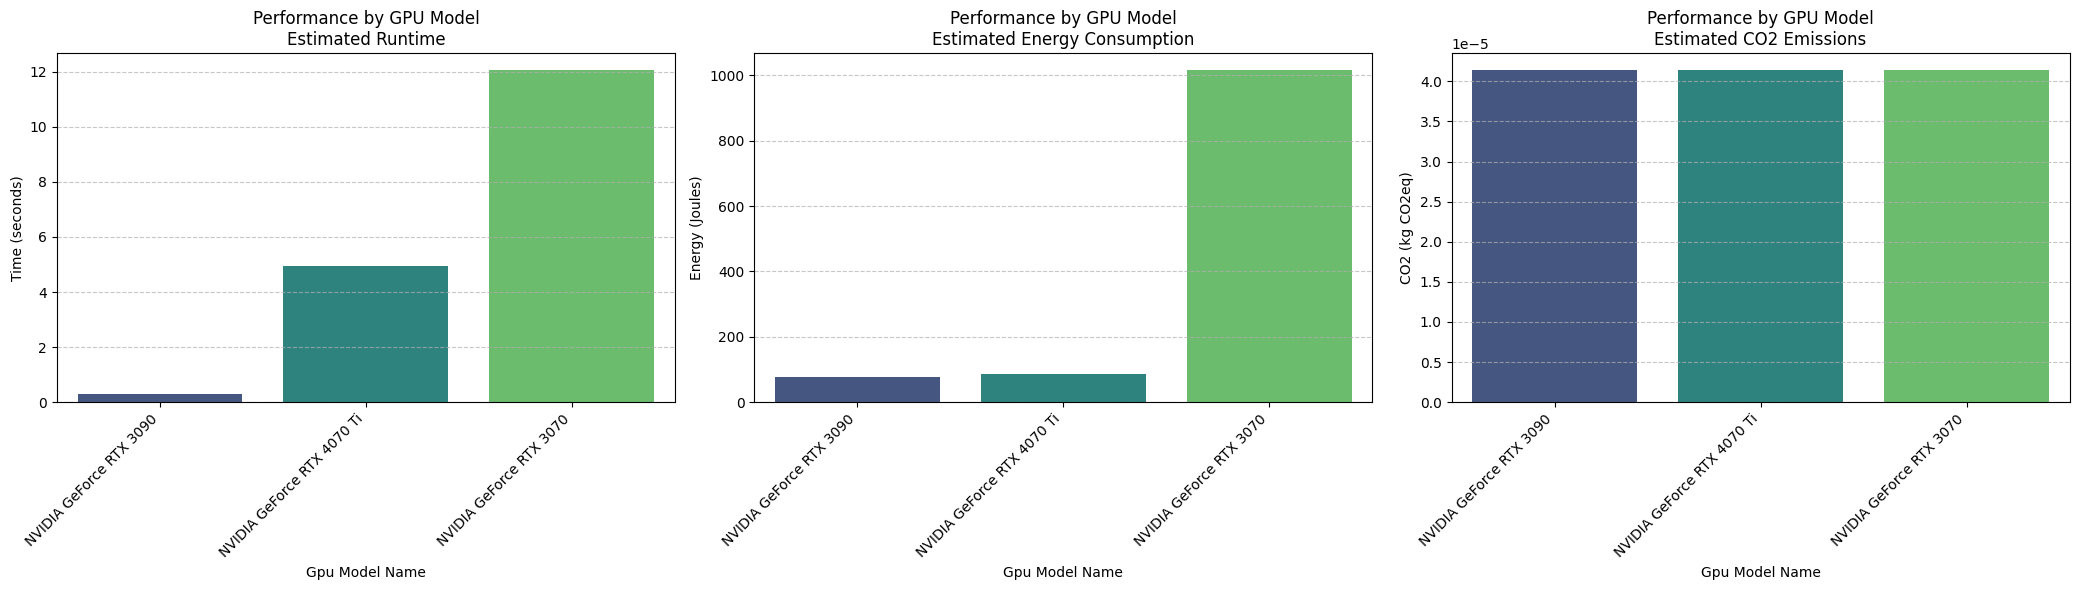


--- Generating LLM Model Comparison Graph ---


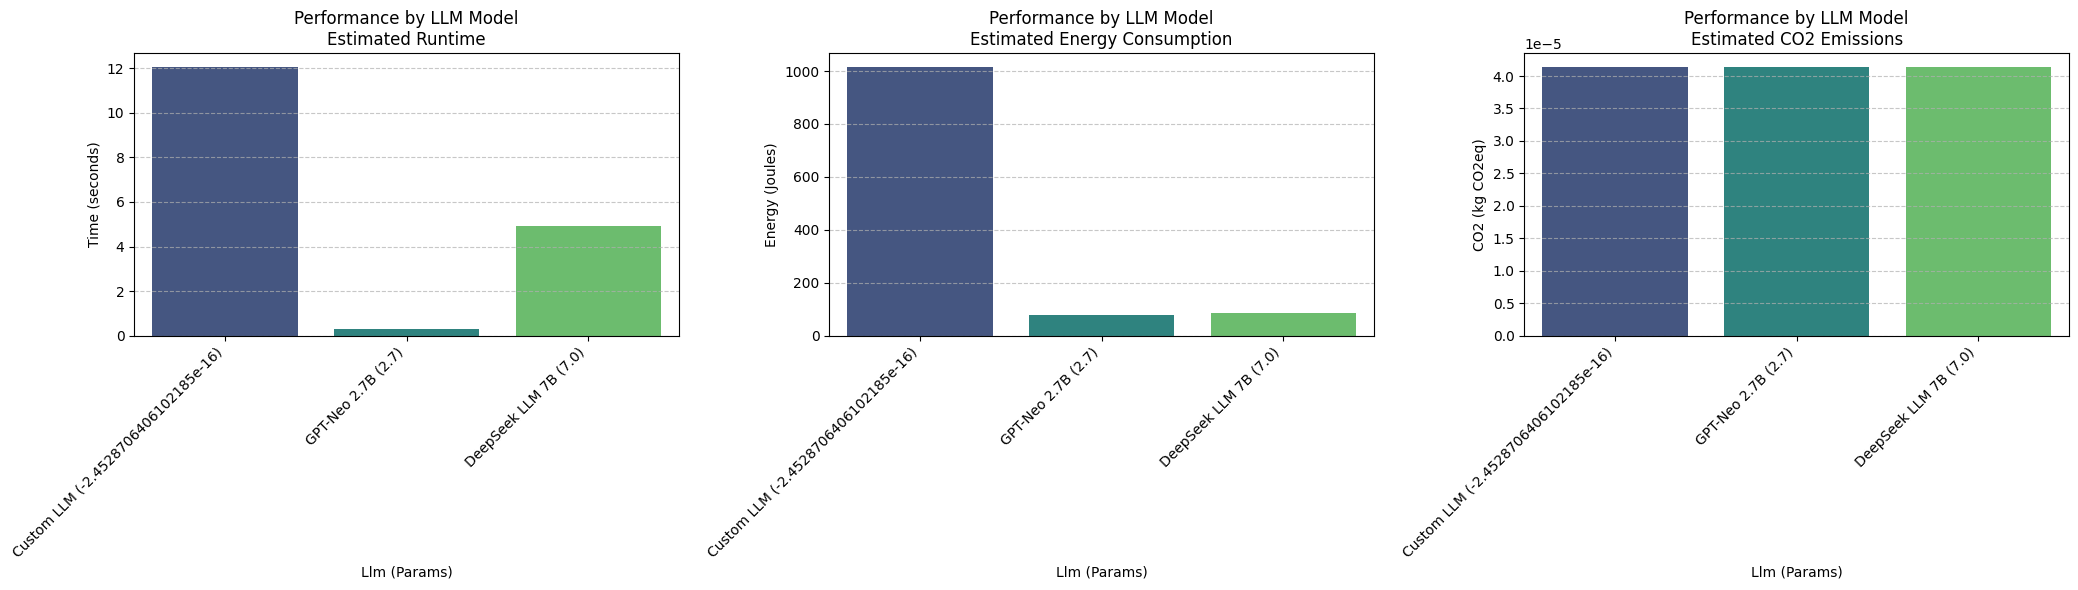


--- Specific Scenario Plotting Finished ---


In [28]:
# --- Plotting Functions ---
def plot_performance_by_category(df, category_col, title_prefix, sort_by_col=None):
    """
    Generates bar plots for Runtime, Energy, and CO2, grouped by a specified category.
    """
    metrics = ['estimated_runtime_s', 'estimated_energy_J', 'estimated_co2_kg_direct']
    titles = {
        'estimated_runtime_s': 'Estimated Runtime',
        'estimated_energy_J': 'Estimated Energy Consumption',
        'estimated_co2_kg_direct': 'Estimated CO2 Emissions'
    }
    y_labels = {
        'estimated_runtime_s': 'Time (seconds)',
        'estimated_energy_J': 'Energy (Joules)',
        'estimated_co2_kg_direct': 'CO2 (kg CO2eq)'
    }

    # Ensure consistent sorting if specified
    if sort_by_col and sort_by_col in df.columns:
        df_sorted = df.sort_values(by=sort_by_col, ascending=True).copy()
    else:
        df_sorted = df.copy()

    fig, axes = plt.subplots(1, len(metrics), figsize=(len(metrics) * 7, 6))
    if len(metrics) == 1:
        axes = [axes]

    for i, metric in enumerate(metrics):
        # Using hue=category_col and legend=False to resolve Seaborn FutureWarning
        sns.barplot(x=category_col, y=metric, data=df_sorted, ax=axes[i], palette='viridis', hue=category_col, legend=False)
        axes[i].set_title(f'{title_prefix}\n{titles[metric]}')
        axes[i].set_xlabel(category_col.replace('_', ' ').title())
        axes[i].set_ylabel(y_labels[metric])

        # FIX for UserWarning: set_ticklabels() should only be used with a fixed number of ticks
        # Get the tick labels and then set their properties
        plt.setp(axes[i].get_xticklabels(), rotation=45, ha='right')

        axes[i].grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

# --- Plotting for GPU Comparison ---
print("\n--- Generating GPU Comparison Graph ---")
# DEBUG: Print columns of results_df right before plotting
print(f"DEBUG: Columns in results_df before GPU plotting: {results_df.columns.tolist()}")

if not results_df.empty:
    plot_performance_by_category(results_df, 'gpu_model_name', 'Performance by GPU Model', sort_by_col='estimated_runtime_s')
else:
    print("No results to plot for GPU comparison.")


# --- Plotting for LLM Model Comparison ---
print("\n--- Generating LLM Model Comparison Graph ---")
if not results_df.empty:
    llm_plot_df = results_df.copy()
    # Ensure 'num_params_str' is treated as string for concatenation
    llm_plot_df['LLM (Params)'] = llm_plot_df['llm_model_name'].astype(str) + ' (' + llm_plot_df['num_params_B'].astype(str) + ')'
    
    # Use 'num_params_B' which is numeric for sorting LLMs by parameter count
    plot_performance_by_category(llm_plot_df, 'LLM (Params)', 'Performance by LLM Model', sort_by_col='num_params_B')
else:
    print("No results to plot for LLM model comparison.")

print("\n--- Specific Scenario Plotting Finished ---")